In [5]:
import sys
sys.path.append('C:/Users/smithlab/Documents/Aaron/Modules/')
import numpy as np
from matplotlib import pyplot as plt
import VNA_control_unratioed as vc
import stage_control as sc
import scipy.constants

## Parameters

In [11]:
C = scipy.constants.c
fstart = 9.5E9
fstop = 10.5E9
NumFreqs = 401
f = np.linspace(fstart, fstop, NumFreqs)
f_indx = np.argmin(np.abs(f - 10E9))
lam_max = C/fstop
k = 2*np.pi*f/C
IFBW = 1000

xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm
speedmms = 25

## Initialize instruments

In [12]:
## Stage
# g = sc.stage_start('169.254.225.173')
# sc.stage_home(g,speedmms)

# VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW)

Agilent Technologies,N5222A,MY51421573,A.09.90.10
Initiating VNA...

Done



## Move to new origin

In [8]:
center_x = -xrange/2;
center_y = -yrange/2;
pos_x = -80;  # adjust to change x zero position
pos_y = -130;  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

(-580.0, -630.0)

## Zero axes

In [9]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g);

## Move to new positions

In [72]:
pos_x = 100;  # adjust to change x zero position
pos_y = 0;  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,pos_x,pos_y)

(100.0, -0.0)

## Take measurements

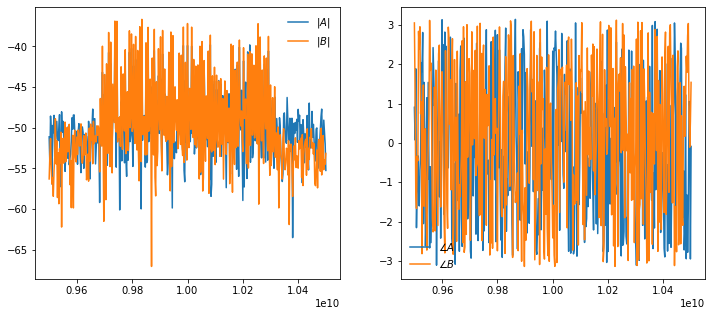

In [82]:
N_realizations = 1000

measurements = np.empty((N_realizations, f.size, 2), dtype=np.complex128)
for i in range(N_realizations):
    measurements[i,:,:] = vc.VNA_read(vna)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(f, 10*np.log10(np.abs(measurements[0,:,0])), label=r'$|A|$')
ax1.plot(f, 10*np.log10(np.abs(measurements[0,:,1])), label=r'$|B|$')
ax1.legend(frameon=False)
ax2.plot(f, np.angle(measurements[0,:,0]), label=r'$\angle A$')
ax2.plot(f, np.angle(measurements[0,:,1]), label=r'$\angle B$')
ax2.legend(frameon=False)

In [83]:
# fig, (ax1) = plt.subplots(1, figsize=(12, 5))
# # ax1.plot(f, 10*np.log10(np.abs(measurements[0,:,0])), label=r'$|A|$')
# # ax1.plot(f, 10*np.log10(np.abs(measurements[0,:,1])), label=r'$|B|$')
# ax1.set_xlim(9.9E9, 10.1E9)
# ax1.plot(f, np.angle(measurements[0,:,0]), label=r'$\angle A$')
# ax1.plot(f, np.angle(measurements[0,:,1]*np.exp(1j*2)), label=r'$\angle B$')

## Compare with theory

In [84]:
x_source = pos_x/1000
y_source = pos_y/1000
z_source = 0.13

x1 = -.07
y1 = 0
z1 = 0

x2 = .07
y2 = 0
z2 = 0

def green(x1, y1, z1, x2, y2, z2, k):
    R = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return np.exp(-1j*k*R)/R

v_theory = np.conjugate(green(x_source, y_source, z_source, x1, y1, z1, k)) * green(x_source, y_source, z_source, x2, y2, z2, k)
v_exp = np.mean(np.conjugate(measurements[:,:,0]) * measurements[:,:,1], axis=0)


In [85]:
# R = np.sqrt((x_source - x2)**2 + (x_source - y2)**2 + (x_source - z2)**2)
# plt.plot(np.real(np.exp(-1j*k*R)/R))
# R = np.sqrt((x1 - x_source)**2 + (y1 - x_source)**2 + (z1 - x_source)**2)
# plt.plot(np.real(np.exp(-1j*k*R)/R))

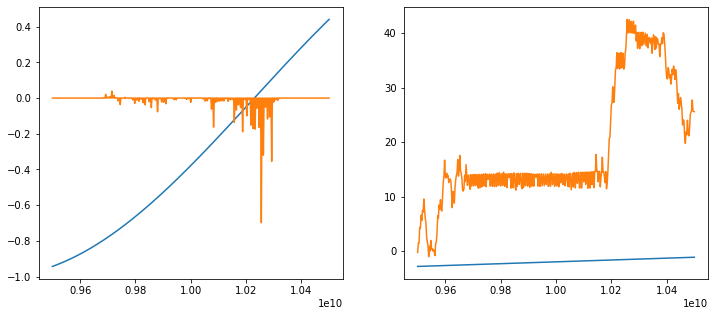

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(f, np.real(v_theory)/np.max(np.abs(v_theory)))
ax1.plot(f, np.real(v_exp)/np.max(np.abs(v_exp)))
# ax2.plot(f, np.imag(v_theory)/np.max(np.abs(v_theory)))
# ax2.plot(f, np.imag(v_exp)/np.max(np.abs(v_exp)))
# ax1.plot(f, np.abs(v_theory)/np.max(np.abs(v_theory)))
# ax1.plot(f, np.abs(v_exp)/np.max(np.abs(v_exp)))
ax2.plot(f, np.angle(v_theory))
ax2.plot(f, np.unwrap(np.angle(v_exp)))
# ax2.set_xlim(9.9E9, 10.1E9)

## Clean up communications

In [25]:
sc.close_connection(g)
vna.close()

Controller connection stopped
